### Практическая работа к уроку №5

#### 1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)

In [136]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import (f1_score, roc_auc_score, precision_score,
                            classification_report, precision_recall_curve,
                            confusion_matrix)
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import itertools

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [40]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [47]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]
    
class MyStandardScaler(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
    
    def fit(self, X, y=None):
        self.mean = X[self.key].mean()
        self.std = X[self.key].std()
        return self
    
    def transform(self, X, y=None):
        return (X[[self.key]] - self.mean) / self.std

In [33]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [48]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('std_scaler', MyStandardScaler(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))

feats = FeatureUnion(final_transformers)
feature_processing = Pipeline([('feats', feats)])

In [124]:
def get_metrics(y_true, y_pred):
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

    fscore = (2 * precision * recall) / (precision + recall)
    # Максимизируем fscore, объяснение во 2 пункте работы
    ix = np.argmax(fscore)
    
    return fscore[ix], precision[ix], recall[ix], roc_auc_score(y_true, y_pred), thresholds[ix]

In [125]:
def train_pipeline(classifier):
    pipeline = Pipeline([
        ('features',feats),
        ('classifier', classifier)
    ])
    pipeline.fit(X_train, y_train);
    preds = pipeline.predict_proba(X_test)[:, 1]
    metrics = get_metrics(y_test, preds)
    
    return metrics, preds

In [126]:
model_gbc = GradientBoostingClassifier(random_state = 42)
model_lr = LogisticRegression(random_state = 42)

results = {}
models_preds = {}

for model in [model_gbc, model_lr]:
    metrics, preds = train_pipeline(model)
    results[type(model).__name__] = metrics
    models_preds[type(model).__name__] = preds

In [127]:
df_results = pd.DataFrame.from_dict(results, orient='index',
                                   columns = ['fscore', 'precision', 
                                              'recall', 'roc_auc_score', 'threshold'])
df_results

,fscore,precision,recall,roc_auc_score,threshold
GradientBoostingClassifier,0.646121,0.703704,0.59725,0.875746,0.408508
LogisticRegression,0.509700,0.462400,0.56778,0.772082,0.289488


#### 2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)

Наиболее подходящей метрикой является fscore.
Рассмотрим причины

recall показывает тот случай, когда пользователь ушел в отток, а модель предсказала обратное. При подобных ошибках компания теряет всю возможную прибыль от клиента, ушедшего в отток.
Но если максимизировать recall, то модель будет стремиться давай скидки всем (порог будет очень низким), чтобы стараться удержать всех клиентов. Соответсвенно компания будет терять большие деньги на раздачу ненужных скидок

precision показывает тот случай, когда клиент не ушел бы в отток, но модель посчитала обратное. При подобных ошибках мы просто потеряем деньги, потраченные на скидку для этого клиента.
Если максимизировать precision, то порог будет слишком высоким, и модель будет стремиться давать как можно меньше скидок. И по этой причине модель будет пропускать мимо себя тех клиентов, которые собираются уйти в отток.

Исходя из вышеизложенного, fscore поможет нам балансировать между precision и recall, потому что эти 2 метрики одновременно важны в данной задаче. 

Лучшей оказалась модель GradientBoostingClassifier

#### 3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.

In [128]:
preds_gbc = models_preds['GradientBoostingClassifier']
threshold_gbc = results['GradientBoostingClassifier'][-1]

In [129]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


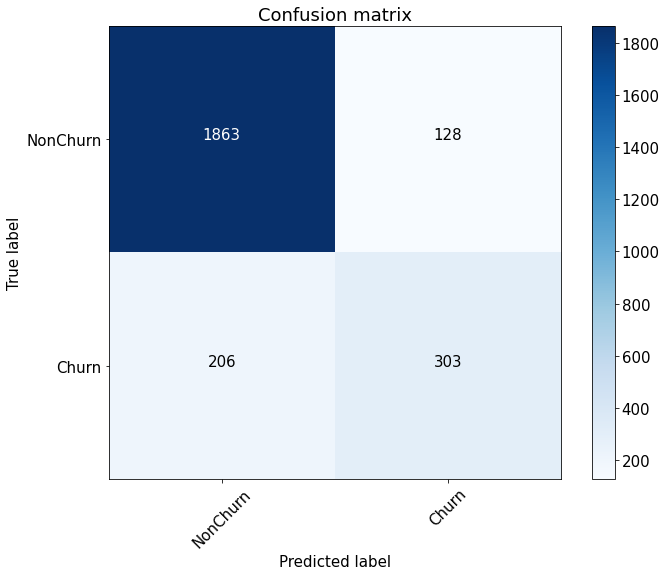

In [130]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_gbc>threshold_gbc)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.show()

Рассчитаем прибыль

Расходы - деньги потраченные на скидки, то есть (303 + 128) * 1 <br>
Потерянные деньги - возможная прибыль со всех ушедших клиентов: (206 + 303) * 2 <br>
Доход - прибыль со всех оставшихся клиентов: (1863 + 128) * 2

In [135]:
(1863 + 128) * 2 - (206 + 303) * 2 - (303 + 128) * 1

2533

Прибыль составила 2533 доллара

#### 4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3

In [141]:
from sklearn.model_selection import GridSearchCV

params={'classifier__n_estimators':[100, 150, 200],
        'classifier__min_samples_leaf':[1, 2, 3],
        'classifier__max_depth': [3, 5, 7, 10]
        }
pipeline = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

grid = GridSearchCV(pipeline,
                    param_grid=params,
                    cv=6,
                    refit=True,
                    scoring='f1')

search = grid.fit(X_train, y_train)
search.best_params_

{'classifier__max_depth': 3,
 'classifier__min_samples_leaf': 1,
 'classifier__n_estimators': 200}

In [142]:
preds = search.predict_proba(X_test)[:, 1]
metrics = get_metrics(y_test, preds)
threshold = metrics[-1]

Confusion matrix, without normalization


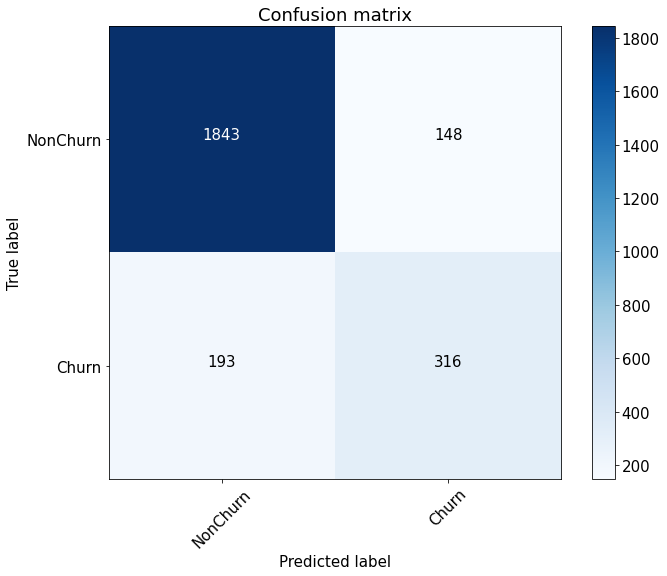

In [143]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>threshold)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.show()

#### 5. (опционально) Еще раз провести оценку экономической эффективности

Рассчитаем прибыль

Расходы - деньги потраченные на скидки: (316 + 148) * 1 <br>
Потерянные деньги - возможная прибыль со всех ушедших клиентов: (193 + 316) * 2 <br>
Доход - прибыль со всех оставшихся клиентов: (1843 + 148) * 2

In [144]:
(1843 + 148) * 2 - (193 + 316) * 2 - (316 + 148) * 1

2500